<a href="https://colab.research.google.com/github/jcmachicao/deeplearning_gestionpublica/blob/main/nn_load_clas_austincrime.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Instalaciones necesarias para GPU Rental
!pip install pandas
!pip install scikit-learn
!pip install matplotlib

### Librerías

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

In [ ]:
import time
import math
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

### Verificación de GPU

In [ ]:
# Verificación de GPU
torch.cuda.device_count(), torch.cuda.get_device_name(0)

(1, 'Tesla K80')

### Carga de Datos

In [ ]:
# Acondicionar la ruta dependiendo del entorno en el que se trabaja
#ruta = 'D:\2021_mod\mod_lineatiempo_papa\model_carga\'
#ruta = 'D://2021_mod/austin_crime_analysis/'
ruta = 'drive/My Drive/00 Modelos Principales/modelos/austin_crime/'

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
X_np = np.load(ruta + 'X_np.npy')
y_np = np.load(ruta + 'y_np.npy')
print(X_np.shape, y_np.shape)

(7782, 46) (7782,)


In [ ]:
X = torch.from_numpy(X_np.astype('float64'))
y = torch.squeeze(torch.from_numpy(np.array(y_np)))
print(X.shape, y.shape)

torch.Size([7782, 46]) torch.Size([7782])


In [ ]:
y_cats = ['Theft: Shoplifting', 'Auto Theft', 'Aggravated Assault', 'Robbery', 'Theft: Pocket Picking', 'Rape']

### Arquitectura de Red

In [ ]:
n_cols = X_np.shape[1]
n_cats = len(y_cats)
print(n_cols, n_cats)

46 6


In [ ]:
# Arquitectura
class NetClas(nn.Module):

  def __init__(self):
    super(NetClas, self).__init__()
    self.fc1 = nn.Linear(n_cols, 512)
    self.fc2 = nn.Linear(512, 256)
    self.fc3 = nn.Linear(256, 32)
    self.fc4 = nn.Linear(32, n_cats)
    self.dp1 = nn.Dropout(0.15)

  def forward(self, x):
    x = F.relu(self.fc1(x))
    x = self.dp1(F.relu(self.fc2(x)))
    x = self.dp1(F.relu(self.fc3(x)))
    x = self.fc4(x)
    return F.log_softmax(x, dim=1)

In [ ]:
model = NetClas()

### Rescate de modelo entrenado

In [ ]:
model

NetClas(
  (fc1): Linear(in_features=46, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=32, bias=True)
  (fc4): Linear(in_features=32, out_features=6, bias=True)
  (dp1): Dropout(p=0.15, inplace=False)
)

In [ ]:
nom_model = ruta + 'modelo_austin_clas_v6.pth'
modelo_load = nom_model
model.load_state_dict(torch.load(modelo_load, map_location=torch.device('cpu')))

<All keys matched successfully>

### Montaje de Elementos en CUDA

In [ ]:
model.cuda(0)
#X_g = X_cv.cuda(0)
X_g = X.cuda(0)
y_g = y.cuda(0)
X_g.shape, y_g.shape

(torch.Size([7782, 46]), torch.Size([7782]))

### Testing

In [ ]:
pred_df = pd.DataFrame()
out = model(X_g.float())
y_hat = torch.argmax(out, 1).cpu().detach()
pred_df['y_orig'] = y.long()
pred_df['y_hat'] = y_hat
pred_df.to_excel(ruta + 'pred_austin_clas_v6__.xlsx')

In [ ]:
(pred_df.y_orig == pred_df.y_hat).sum()/len(pred_df)

0.9491133384734002

In [ ]:
pred_df.pivot_table(values=)

,y_orig,y_hat
0,0,0
1,1,3
2,1,1
3,0,1
4,2,2
...,...,...
7777,0,0
7778,4,4
7779,0,0
7780,2,3


### Continua Entrenamiento

In [ ]:
nit = -1
learning_rate = 0.001
errores = []
precision = []

In [ ]:
# Para clasificación
criterion = nn.NLLLoss() 
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
#criterion = nn.CrossEntropyLoss() # Para clasificación

# Para regresión
#criterion = nn.MSELoss()  
#optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

In [ ]:
num_epochs = 500

In [ ]:
for c in range(5):
    
  print('Ciclo: ', c)
  nit += 1
  start = time.time()

  for epoch in range(num_epochs):
        
    optimizer.zero_grad()
    scores = model(X_g.float())
    loss = F.nll_loss(scores, y_g.long())
    #loss = criterion(scores, y)
    loss.backward()
    optimizer.step()
    
    if epoch % int(num_epochs/10) == 0:
        
        end = time.time()
        errores.append([epoch+nit*num_epochs, loss.item()])
        
        pred = scores.cpu().detach().numpy()
        predicts = pd.DataFrame(np.argmax(pred, 1))
        predicts.columns = ['preds']
        predicts['y_orig'] = y
        predicts['acierto'] = (predicts.preds == predicts.y_orig)*1
        precis = predicts.acierto.sum()/len(predicts)
        precision.append(precis)
        
        print(epoch+nit*num_epochs, '{0: .5f}'.format(loss.item()), '{0: .2f}'.format(end-start),  '{0: .4f}'.format(precis))
        start = end
        
print('Ciclo Finalizado')

Ciclo:  0
14500  0.13523  0.01  0.9406
14550  0.12020  0.53  0.9463
14600  0.12452  0.50  0.9468
14650  0.12574  0.47  0.9453
14700  0.12533  0.47  0.9463
14750  0.11710  0.47  0.9513
14800  0.12085  0.47  0.9487
14850  0.12138  0.46  0.9494
14900  0.12067  0.47  0.9477
14950  0.12918  0.47  0.9411
Ciclo:  1
15000  0.15192  0.01  0.9320
15050  0.13314  0.53  0.9422
15100  0.11853  0.47  0.9494
15150  0.12082  0.47  0.9490
15200  0.11633  0.47  0.9495
15250  0.11889  0.47  0.9454
15300  0.13340  0.47  0.9409
15350  0.11791  0.47  0.9503
15400  0.11834  0.47  0.9487
15450  0.12342  0.47  0.9463
Ciclo:  2
15500  0.12072  0.01  0.9478
15550  0.11939  0.47  0.9483
15600  0.12012  0.47  0.9495
15650  0.11925  0.47  0.9498
15700  0.12246  0.53  0.9456
15750  0.11661  0.47  0.9486
15800  0.12030  0.46  0.9487
15850  0.11740  0.47  0.9498
15900  0.11731  0.47  0.9468
15950  0.11754  0.47  0.9469
Ciclo:  3
16000  0.12033  0.01  0.9495
16050  0.12125  0.47  0.9463
16100  0.11179  0.47  0.9494
161

In [ ]:
nombre = 'austin_clas_'
version = 'v6'

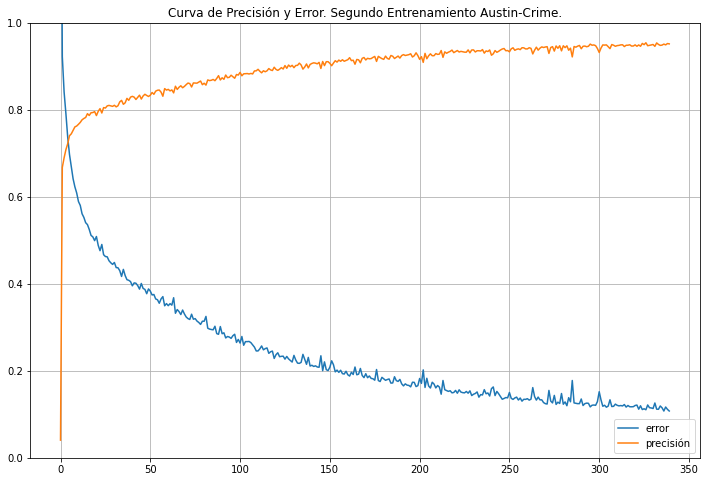

In [ ]:
err_df = pd.DataFrame(errores)
prec_df = pd.DataFrame(precision)

plt.figure(figsize=(12,8))
plt.plot(err_df[1], label='error')
plt.plot(prec_df[0], label='precisión')
plt.grid(True)
plt.title('Curva de Precisión y Error. Segundo Entrenamiento Austin-Crime.')
plt.legend(loc='best')
plt.ylim(0,1)
plt.savefig('error_precision'+nombre+version+'.png')
plt.show()

In [ ]:
torch.save(model.state_dict(), ruta + 'modelo_'+nombre+version+'.pth')
pred_df = pd.DataFrame(pred)
pred_df.to_csv(ruta + 'preds_'+nombre+version+'.csv')
errores_df = pd.DataFrame(errores)
errores_df.to_csv(ruta + 'errors_'+nombre+version+'.csv')

In [ ]:
pred = scores.cpu().detach().numpy()
predicts = pd.DataFrame(np.argmax(pred, 1))
predicts.columns = ['preds']
predicts['y_orig'] = y
predicts['acierto'] = (predicts.preds == predicts.y_orig)*1
predicts.to_csv(ruta + 'predic__'+nombre+version+'.csv')